# YouTube Data Collection and Analysis

#### To collect data from YouTube, we first need to define what specific information we need. Let’s focus on gathering data about trending videos to analyze what factors contribute to a video's success on the platform.

### So, let’s start with data collection first. To collect data from YouTube, you need to set up an API. Here are the steps you can follow:

* Go to Google Cloud Console.
* Click on the project drop-down at the top, then “New Project”.
* Enter a project name and click “Create”.
* In the Google Cloud Console, navigate to “APIs & Services” > “Library”.
* Search for “YouTube Data API v3” and click on it.
* Click “Enable”.
* Go to “APIs & Services” > “Credentials”.
* Click “+ CREATE CREDENTIALS” and select “API key”.
* Copy the generated API key.

### Creating function filter warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')

### collecting data about the top 200 trending videos on YouTube

In [2]:
# Install the Google API client library (pip install google-api-python-client)
# Run this command in your terminal or add it to the top of your script if using a notebook
# !pip install google-api-python-client

import pandas as pd
from googleapiclient.discovery import build

# replace with your own API key
API_KEY = 'You API Key'

def get_trending_videos(api_key, max_results=200):
    # build the youtube service
    youtube = build('youtube', 'v3', developerKey=api_key)

    # initialize the list to hold video details
    videos = []

    # fetch the most popular videos
    request = youtube.videos().list(
        part='snippet,contentDetails,statistics',
        chart='mostPopular',
        regionCode='US',  
        maxResults=50
    )

    # paginate through the results if max_results > 50
    while request and len(videos) < max_results:
        response = request.execute()
        for item in response['items']:
            video_details = {
                'video_id': item['id'],
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'published_at': item['snippet']['publishedAt'],
                'channel_id': item['snippet']['channelId'],
                'channel_title': item['snippet']['channelTitle'],
                'category_id': item['snippet']['categoryId'],
                'tags': item['snippet'].get('tags', []),
                'duration': item['contentDetails']['duration'],
                'definition': item['contentDetails']['definition'],
                'caption': item['contentDetails'].get('caption', 'false'),
                'view_count': item['statistics'].get('viewCount', 0),
                'like_count': item['statistics'].get('likeCount', 0),
                'dislike_count': item['statistics'].get('dislikeCount', 0),
                'favorite_count': item['statistics'].get('favoriteCount', 0),
                'comment_count': item['statistics'].get('commentCount', 0)
            }
            videos.append(video_details)

        # get the next page token
        request = youtube.videos().list_next(request, response)

    return videos[:max_results]

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def main():
    trending_videos = get_trending_videos(API_KEY)
    filename = 'trending_videos.csv'
    save_to_csv(trending_videos, filename)
    print(f'Trending videos saved to {filename}')

if __name__ == '__main__':
    main()

Trending videos saved to trending_videos.csv


### *The above code uses the YouTube Data API to fetch details of the top 200 trending videos in the US. It iterates through paginated responses to collect video details like title, description, published date, channel info, tags, duration, definition, captions, views, likes, and comments. This data is compiled into a list, converted to a pandas DataFrame, and saved as `trending_videos.csv` for trend analysis.*

In [3]:
import pandas as pd

trending_videos = pd.read_csv('trending_videos.csv')
print(trending_videos.head())

      video_id                                              title  \
0  H58vbez_m4E                       Kendrick Lamar - Not Like Us   
1  LRP9fsptFHI  I Adopted a Sister and Hid from my dad! Salish...   
2  XkkNfR_MDiM        Minecraft but I survive in PVP CIVILIZATION   
3  ouBhzqQmheg                               I Bought EVERY CROCS   
4  SUaOxp5U_yg               MrBeast’s 24 Hour Survival Challenge   

                                         description          published_at  \
0  Kendrick Lamar “Not Like Us”\nDirected by Dave...  2024-07-04T23:00:09Z   
1  I've always wanted a sister so I adopted my fr...  2024-07-06T14:25:07Z   
2  Minecraft but I survive in PVP CIVILIZATION......  2024-07-06T14:19:05Z   
3  Buying EVERY style of CROCS :) Everything from...  2024-07-06T14:30:30Z   
4  In this weeks episode, the gang gets challenge...  2024-07-06T00:00:23Z   

                 channel_id      channel_title  category_id  \
0  UCoYfzC2zMlc9M-Odgaf6OSg  KendrickLamarVEVO       

In [4]:
# check for missing values
missing_values = trending_videos.isnull().sum()

# display data types
data_types = trending_videos.dtypes

missing_values, data_types

(video_id          0
 title             0
 description       1
 published_at      0
 channel_id        0
 channel_title     0
 category_id       0
 tags              0
 duration          0
 definition        0
 caption           0
 view_count        0
 like_count        0
 dislike_count     0
 favorite_count    0
 comment_count     0
 dtype: int64,
 video_id          object
 title             object
 description       object
 published_at      object
 channel_id        object
 channel_title     object
 category_id        int64
 tags              object
 duration          object
 definition        object
 caption             bool
 view_count         int64
 like_count         int64
 dislike_count      int64
 favorite_count     int64
 comment_count      int64
 dtype: object)

### *The description column has 1 missing values. This is minor and can be handled as needed. The data types seem appropriate for most columns, but we may need to convert the published_at column to a datetime format and tags might need further processing. Let’s fix these changes:*

In [5]:
# fill missing descriptions with "No description"
trending_videos['description'].fillna('No description', inplace=True)

# convert `published_at` to datetime
trending_videos['published_at'] = pd.to_datetime(trending_videos['published_at'])

# convert tags from string representation of list to actual list
trending_videos['tags'] = trending_videos['tags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [6]:
# descriptive statistics
descriptive_stats = trending_videos[['view_count', 'like_count', 'dislike_count', 'comment_count']].describe()

descriptive_stats

,view_count,like_count,dislike_count,comment_count
count,2.000000e+02,2.000000e+02,200.0,200.000000
mean,3.276698e+06,1.429396e+05,0.0,7674.950000
std,1.298019e+07,5.961296e+05,0.0,25365.601997
min,1.032870e+05,0.000000e+00,0.0,0.000000
25%,3.932155e+05,1.227250e+04,0.0,1206.250000
50%,7.313330e+05,2.674050e+04,0.0,2362.000000
75%,1.675296e+06,7.258875e+04,0.0,4843.250000
max,1.569493e+08,5.532373e+06,0.0,224030.000000


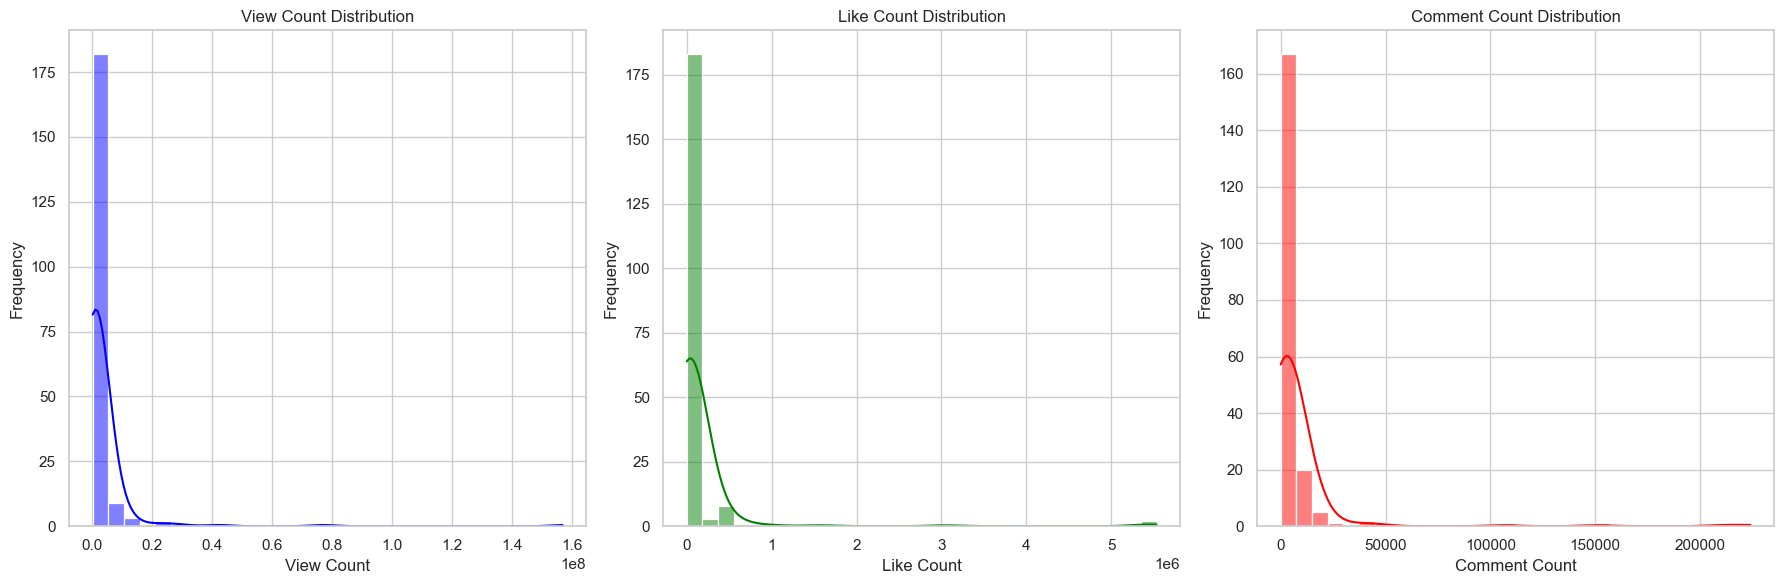

In [7]:
# distribution of views, likes and comments of all the videos in the data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# view count distribution
sns.histplot(trending_videos['view_count'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('View Count Distribution')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Frequency')

# like count distribution
sns.histplot(trending_videos['like_count'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Like Count Distribution')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('Frequency')

# comment count distribution
sns.histplot(trending_videos['comment_count'], bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Comment Count Distribution')
axes[2].set_xlabel('Comment Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### *The histograms illustrate that view counts, like counts, and comment counts are right-skewed, with most videos showing lower counts and only a few showing extremely high counts. Next, let’s look at the correlation among likes, views, and comments:*

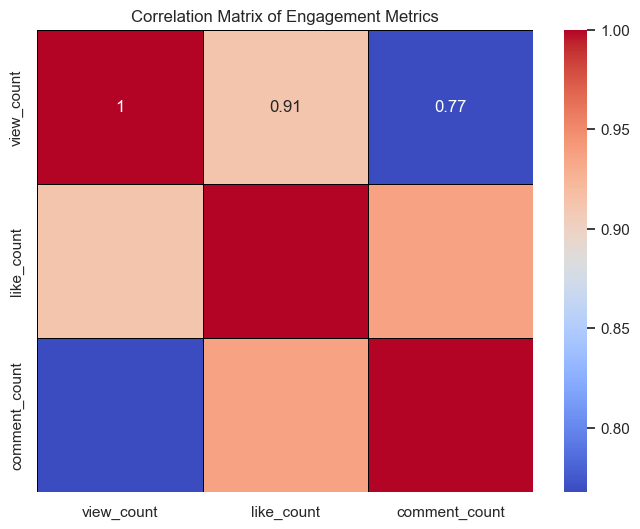

In [8]:
# correlation matrix
correlation_matrix = trending_videos[['view_count', 'like_count', 'comment_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Engagement Metrics')
plt.show()

### *The heatmap confirms strong positive correlations among views, likes, and comments. I realized that only the category ID was collected, so let’s also collect the category names to further analyze trending video categories.*

In [9]:
from googleapiclient.discovery import build

API_KEY = 'You API Key'
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_category_mapping():
    request = youtube.videoCategories().list(
        part='snippet',
        regionCode='US'
    )
    response = request.execute()
    category_mapping = {}
    for item in response['items']:
        category_id = int(item['id'])
        category_name = item['snippet']['title']
        category_mapping[category_id] = category_name
    return category_mapping

# get the category mapping
category_mapping = get_category_mapping()
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


## analyzing the number of trending videos by category

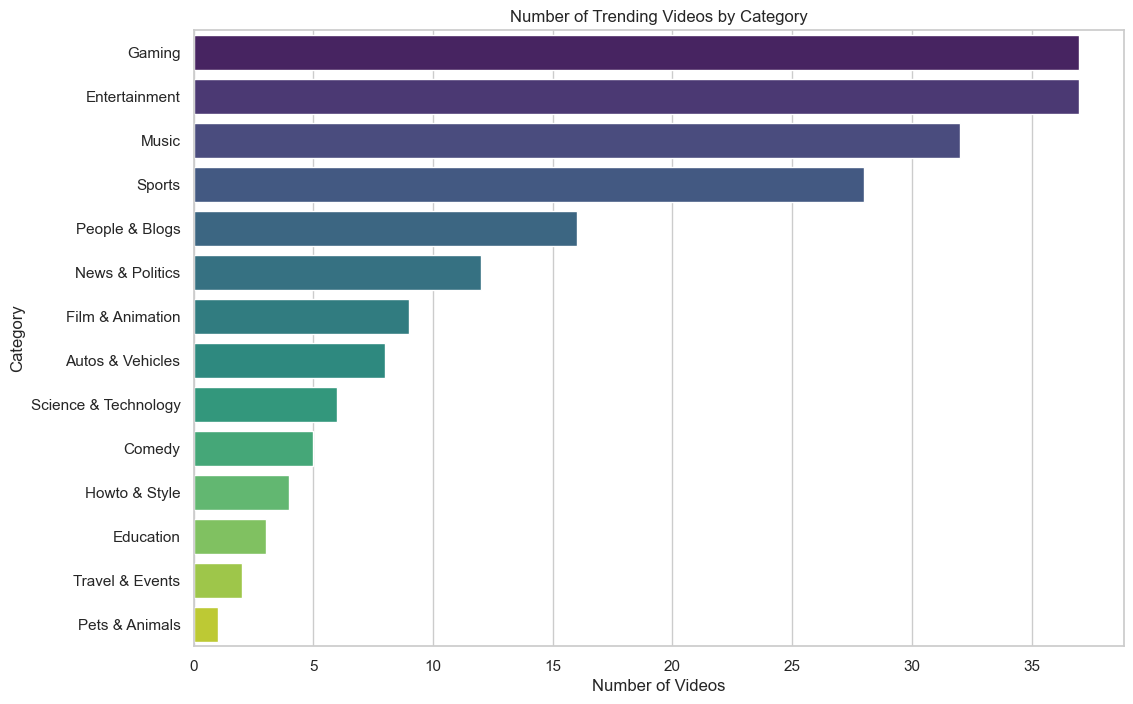

In [10]:
trending_videos['category_name'] = trending_videos['category_id'].map(category_mapping)

# Bar chart for category counts
plt.figure(figsize=(12, 8))
sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index, palette='viridis')
plt.title('Number of Trending Videos by Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.show()

### *The bar chart illustrates that Gaming, Entertainment, Sports, and Music are the categories with the most trending videos. Next, let’s examine the average engagement metrics for each category*

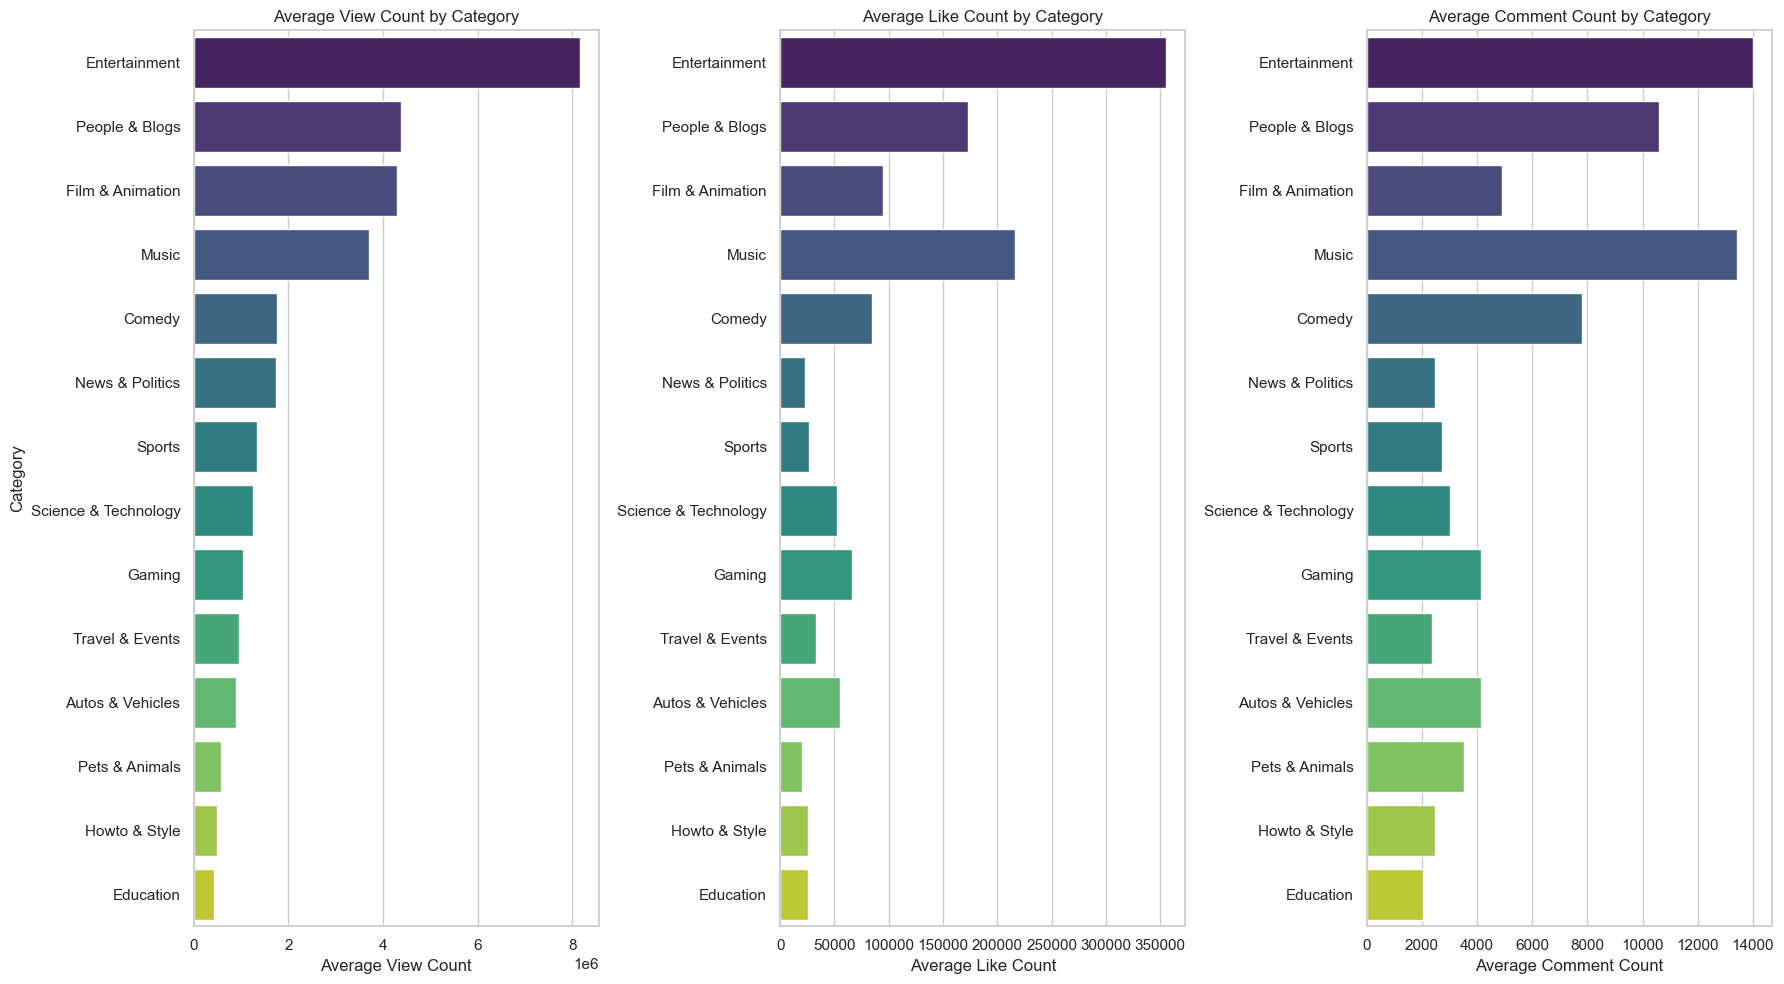

In [11]:
# average engagement metrics by category
category_engagement = trending_videos.groupby('category_name')[['view_count', 'like_count', 'comment_count']].mean().sort_values(by='view_count', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# view count by category
sns.barplot(y=category_engagement.index, x=category_engagement['view_count'], ax=axes[0], palette='viridis')
axes[0].set_title('Average View Count by Category')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Category')

# like count by category
sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1], palette='viridis')
axes[1].set_title('Average Like Count by Category')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by category
sns.barplot(y=category_engagement.index, x=category_engagement['comment_count'], ax=axes[2], palette='viridis')
axes[2].set_title('Average Comment Count by Category')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

### *Music and People & Blogs categories have the highest average view counts, likes, and comments, while Film & Animation also exhibits high engagement, particularly in view counts and likes*

### *Now we will look into the content and duration of the videos. To start, we need to convert the video duration from ISO 8601 format to seconds:*

In [12]:
!pip install isodate
import isodate

# convert ISO 8601 duration to seconds
trending_videos['duration_seconds'] = trending_videos['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

trending_videos['duration_range'] = pd.cut(trending_videos['duration_seconds'], bins=[0, 300, 600, 1200, 3600, 7200], labels=['0-5 min', '5-10 min', '10-20 min', '20-60 min', '60-120 min'])

#### *In the code above, we use the isodate library to convert each video's duration from ISO 8601 format to seconds for numerical analysis. After conversion, we categorize the videos into duration ranges (0-5 minutes, 5-10 minutes, 10-20 minutes, 20-60 minutes, and 60-120 minutes) by creating a new column called duration_range. This categorization helps us analyze and compare engagement metrics across different video length intervals to understand how video length affects viewer behavior and performance.*

## analyzing the content and the duration of videos

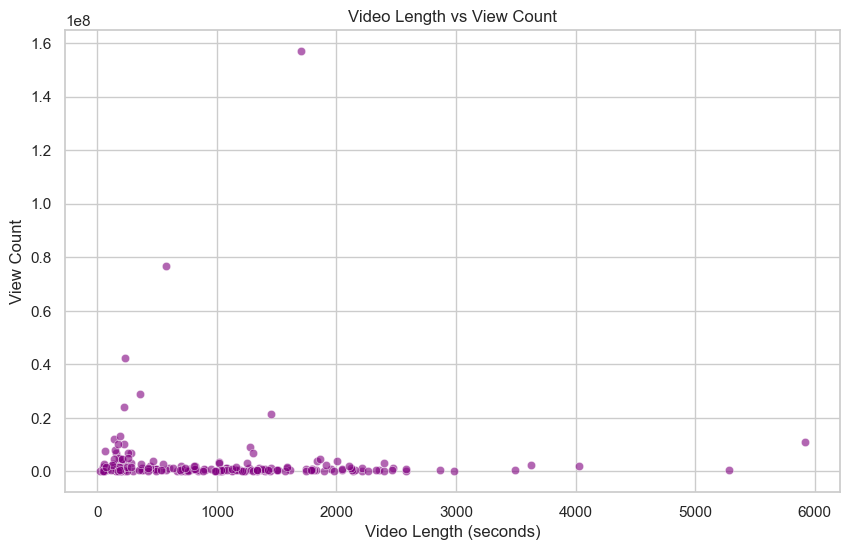

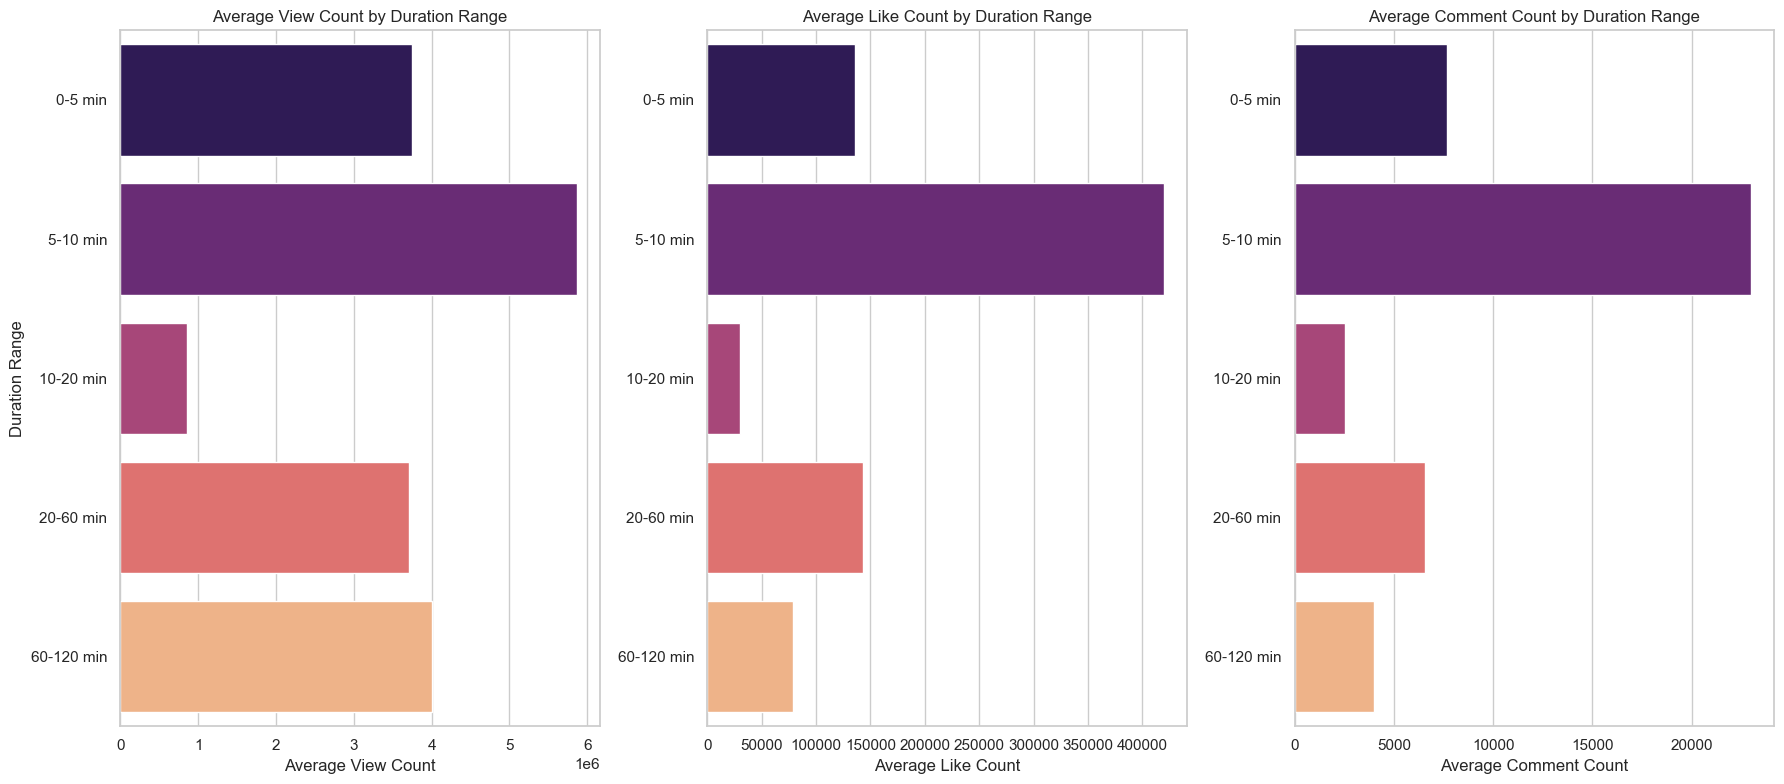

In [13]:
# scatter plot for video length vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_seconds', y='view_count', data=trending_videos, alpha=0.6, color='purple')
plt.title('Video Length vs View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.show()

# bar chart for engagement metrics by duration range
length_engagement = trending_videos.groupby('duration_range')[['view_count', 'like_count', 'comment_count']].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# view count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma')
axes[0].set_title('Average View Count by Duration Range')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Duration Range')

# like count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['like_count'], ax=axes[1], palette='magma')
axes[1].set_title('Average Like Count by Duration Range')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['comment_count'], ax=axes[2], palette='magma')
axes[2].set_title('Average Comment Count by Duration Range')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

#### *The scatter plot reveals a slight negative correlation between video length and view count, suggesting that shorter videos generally attract more views. Videos in the 5-10 minute range show the highest average view counts, likes, and comments.*

### analyzing the relationship between views and number of tags used in the video

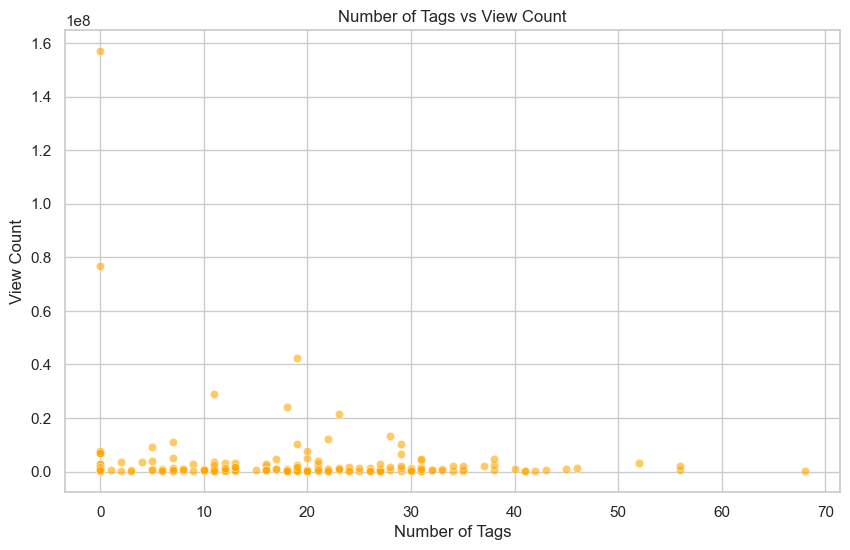

In [14]:
# calculate the number of tags for each video
trending_videos['tag_count'] = trending_videos['tags'].apply(len)

# scatter plot for number of tags vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tag_count', y='view_count', data=trending_videos, alpha=0.6, color='orange')
plt.title('Number of Tags vs View Count')
plt.xlabel('Number of Tags')
plt.ylabel('View Count')
plt.show()

#### *The scatter plot shows a very weak relationship between the number of tags and view count, suggesting that the number of tags has minimal impact on a video’s view count.*

## *Checking if there’s an impact of the time a video is posted on its views*

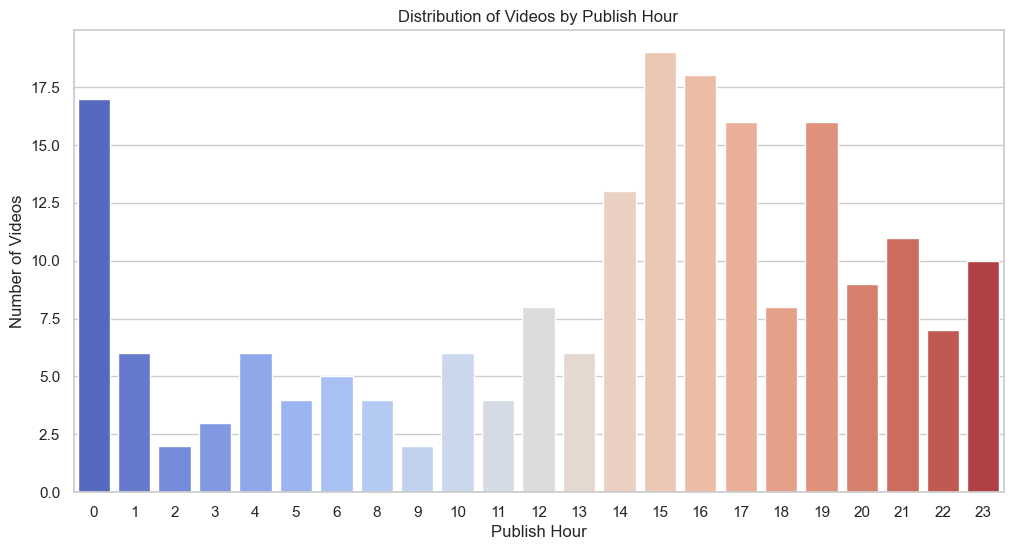

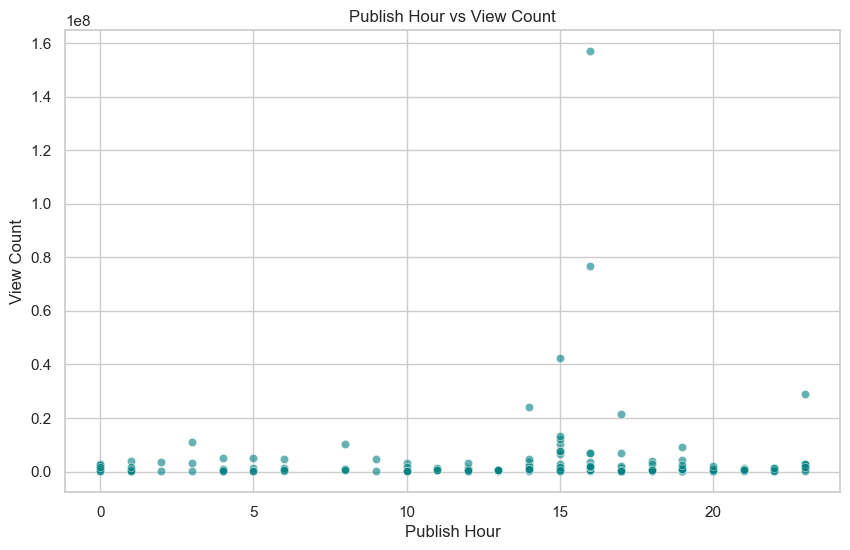

In [15]:
# extract hour of publication
trending_videos['publish_hour'] = trending_videos['published_at'].dt.hour

# bar chart for publish hour distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='publish_hour', data=trending_videos, palette='coolwarm')
plt.title('Distribution of Videos by Publish Hour')
plt.xlabel('Publish Hour')
plt.ylabel('Number of Videos')
plt.show()

# scatter plot for publish hour vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='publish_hour', y='view_count', data=trending_videos, alpha=0.6, color='teal')
plt.title('Publish Hour vs View Count')
plt.xlabel('Publish Hour')
plt.ylabel('View Count')
plt.show()

#### *The distribution indicates that most videos are published between 14:00 and 20:00 hours (2 PM – 8 PM), suggesting this might be an optimal time for video uploads. There is a very weak negative relationship between the hour of publication and view count, implying that the time of day has minimal impact on engagement metrics.*

# Conclusion

So, here’s what I’ve concluded about making a video trend on YouTube:

* Encourage viewers to like and comment to improve engagement metrics.
* Focus on creating shorter or mid length videos (under 10 minutes) for better engagement, particularly in categories like Music and Entertainment.
* Schedule your video uploads during peak times (2 PM – 8 PM) to maximize initial views and boost engagement.